
# Working with coolers

In this notebook, we use files generated by the workflow `master_workflow` that, in short does:

1) Download the data from the source
2) Index the reference genome with `bwa index` and `samtools faidx`
3) Align the reads to the reference genome with `bwa mem`
4) Pair and sort the reads to `.pairs` files with `pairtools parse | pairtools sort`
5) Deduplicate the pairs with `pairtools dedup`
6) Convert the .pairs to cooler files with `cooler cload pairs`

We will:

1) Load the cooler files
2) Merge the coolers from the same BioSample ID --> Create 'replicates'
3) Zoomify the merged cooler files (coarsen) to create a multicooler (.mcool) file
4) Balance the matrices (use commandline `cooler balance`)
5) Calculate E1 compartments with `cooltools compute_cis_eig`

## Overview

### Data (Accessions)

In [86]:
#| echo: false

import pandas as pd

df = pd.read_csv('../data/SraRunTable.txt')[['source_name','Run', 'BioSample', 'Bases','Bytes']].sort_values(['source_name', 'Run'])
df['GB'] = df['Bytes'].apply(lambda x: x / (1024 ** 3))
df['Reads'] = df['Bases']/300
df = df[['source_name', 'BioSample', 'Run', 'GB', 'Bases', 'Reads']]

# Use the style method to format the columns for display
df.style.format({'Bases': '{:,.0f}', 'Reads': '{:,.0f}'})

# Hard code the formatting
# df[['Bases', 'Bytes', 'Reads']] = df[['Bases', 'Bytes', 'Reads']].map(lambda x: f"{int(x):,}")
#df


,source_name,BioSample,Run,GB,Bases,Reads
16,fibroblast,SAMN08375237,SRR6502335,29.771059,"73,201,141,800","244,003,806"
17,fibroblast,SAMN08375237,SRR6502336,22.755361,"65,119,970,100","217,066,567"
18,fibroblast,SAMN08375236,SRR6502337,21.434722,"52,769,196,300","175,897,321"
19,fibroblast,SAMN08375236,SRR6502338,21.420030,"52,378,949,100","174,596,497"
20,fibroblast,SAMN08375236,SRR6502339,10.207410,"28,885,941,600","96,286,472"
9,fibroblast,SAMN08375237,SRR7349189,52.729173,"139,604,854,200","465,349,514"
10,fibroblast,SAMN08375236,SRR7349190,53.085520,"142,008,353,400","473,361,178"
21,pachytene spermatocyte,SAMN08375234,SRR6502342,60.258880,"150,370,993,500","501,236,645"
22,pachytene spermatocyte,SAMN08375234,SRR6502344,27.146048,"65,697,684,300","218,992,281"
23,pachytene spermatocyte,SAMN08375234,SRR6502345,26.202707,"63,490,538,700","211,635,129"


### Folder structure

In [39]:
!tree -d -L 2 ../steps/bwa/PE

../steps/bwa/PE
├── bamfiles
│   ├── fibroblast
│   ├── pachytene_spermatocyte
│   ├── round_spermatid
│   ├── sperm
│   └── spermatogonia
├── cool
│   ├── fibroblast
│   ├── pachytene_spermatocyte
│   ├── round_spermatid
│   ├── sperm
│   └── spermatogonia
└── pairs
    ├── fibroblast
    ├── pachytene_spermatocyte
    ├── round_spermatid
    ├── sperm
    └── spermatogonia

18 directories


## FullMerge (pool all from each source_name)

With `cooler merge`

In [1]:
import glob
import os.path as op
from pprint import pprint as pp

# Get the list of cell type dirs
base_dir = '../steps/bwa/PE/cool'
folders = glob.glob(op.join(base_dir, '*'))

files_dict = {f:glob.glob(f"{f}/*.nodups.*") for f in folders}
cooler_dict = {op.basename(k): [op.basename(f) for f in v] for k,v in files_dict.items()}
cooler_dict_no_fib = {k:v for k,v in cooler_dict.items() if 'fib' not in k}
pp(cooler_dict)

{'fibroblast': ['SRR6502339.nodups.10000.cool',
                'SRR7349190.nodups.10000.cool',
                'SRR7349189.nodups.10000.cool',
                'SRR6502335.nodups.10000.cool',
                'SRR6502338.nodups.10000.cool',
                'SRR6502336.nodups.10000.cool',
                'SRR6502337.nodups.10000.cool'],
 'pachytene_spermatocyte': ['SRR7345459.nodups.10000.cool',
                            'SRR6502344.nodups.10000.cool',
                            'SRR6502342.nodups.10000.cool',
                            'SRR7345458.nodups.10000.cool',
                            'SRR6502345.nodups.10000.cool',
                            'SRR7349191.nodups.10000.cool'],
 'round_spermatid': ['SRR7349192.nodups.10000.cool',
                     'SRR6502353.nodups.10000.cool',
                     'SRR6502352.nodups.10000.cool',
                     'SRR6502351.nodups.10000.cool',
                     'SRR7345460.nodups.10000.cool',
                     'SRR7345461.nodu

In [5]:
# NB adjust `mergebuf` if you don't have 32G of RAM

import cooler

for folder,cooler_list in cooler_dict.items():
    in_uris = [op.join(base_dir, folder, file) for file in cooler_list]
    out_uri = op.join(base_dir, folder, f'{folder}.fullmerge.cool')

    if op.exists(out_uri):
        print(f"Skipping {out_uri}: exists...")
        continue

    print(f"Creating {out_uri} by \nMerging {len(cooler_list)} coolers into one:", end=" ")
    print("\t",[file.split('.')[0] for file in cooler_list])
    cooler.merge_coolers(output_uri=out_uri,
                         input_uris=in_uris,
                         mergebuf=int(5e7),
                         )
    print("... Done!")

Skipping ../steps/bwa/PE/cool/round_spermatid/round_spermatid.fullmerge.cool: exists...
Skipping ../steps/bwa/PE/cool/spermatogonia/spermatogonia.fullmerge.cool: exists...
Skipping ../steps/bwa/PE/cool/sperm/sperm.fullmerge.cool: exists...
Skipping ../steps/bwa/PE/cool/fibroblast/fibroblast.fullmerge.cool: exists...
Skipping ../steps/bwa/PE/cool/pachytene_spermatocyte/pachytene_spermatocyte.fullmerge.cool: exists...


### Zoomify the merged cooler files


In [7]:
# NB 8 cores and 32G of RAM was used

import glob
import cooler
import os.path as op

base_dir = '../steps/bwa/PE/cool'
merged_coolers = glob.glob(op.join(base_dir, '*/*.fullmerge.cool'))


for clr in merged_coolers:
    out_uri = clr.replace('.fullmerge.cool', '.mcool')
    if op.exists(out_uri):
        print(f"Skipping {out_uri}: exists...")
        continue

    print(f"Zoomifying cooler: \n\t   {clr}\n\t-> {out_uri}", end="")
    
    cooler.zoomify_cooler(base_uris = clr,
                          outfile = out_uri,
                          resolutions = [10000,50000,100000,500000],
                          chunksize = 10000000,
                          nproc = 8)
    print(" --> done")

Skipping ../steps/bwa/PE/cool/round_spermatid/round_spermatid.mcool: exists...
Skipping ../steps/bwa/PE/cool/spermatogonia/spermatogonia.mcool: exists...
Skipping ../steps/bwa/PE/cool/sperm/sperm.mcool: exists...
Zoomifying cooler: 
	   ../steps/bwa/PE/cool/fibroblast/fibroblast.fullmerge.cool
	-> ../steps/bwa/PE/cool/fibroblast/fibroblast.mcool --> done
Skipping ../steps/bwa/PE/cool/pachytene_spermatocyte/pachytene_spermatocyte.mcool: exists...


In [15]:
import glob
mcools = glob.glob("../steps/bwa/PE/cool/*/*.mcool")

for mcool in mcools:
    print(f"{mcool}:")
    print(cooler.fileops.list_coolers(mcool))
    print()


../steps/bwa/PE/cool/round_spermatid/round_spermatid.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']

../steps/bwa/PE/cool/spermatogonia/spermatogonia.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']

../steps/bwa/PE/cool/sperm/sperm.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']

../steps/bwa/PE/cool/fibroblast/fibroblast.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']

../steps/bwa/PE/cool/pachytene_spermatocyte/pachytene_spermatocyte.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']



### Balance the matrices

In [2]:
import glob

mcools = glob.glob("../steps/bwa/PE/cool/*/*.mcool")
resolutions = [10000, 50000, 100000, 500000]

for mcool in mcools:
    print(f"Balancing {mcool}:")
    for res in resolutions:
        full_name = f"{mcool}::resolutions/{res}"
        print(f"\tresolution {res}...", end=" ")
        !cooler balance -p 32 {full_name}
        print("--> Done!")

Balancing ../steps/bwa/PE/cool/round_spermatid/round_spermatid.mcool:
	resolution 10000... 

INFO:cooler.cli.balance:Balancing "../steps/bwa/PE/cool/round_spermatid/round_spermatid.mcool::resolutions/10000"
INFO:cooler.balance:variance is 2079661.4027216053
INFO:cooler.balance:variance is 453553.06527791504
INFO:cooler.balance:variance is 122090.58632047936
INFO:cooler.balance:variance is 129190.84140421994
INFO:cooler.balance:variance is 48191.01921909741
INFO:cooler.balance:variance is 40764.260723976775
INFO:cooler.balance:variance is 18356.248248008043
INFO:cooler.balance:variance is 13507.74990364802
INFO:cooler.balance:variance is 6807.56897366601
INFO:cooler.balance:variance is 4602.949620233886
INFO:cooler.balance:variance is 2481.4615818257016
INFO:cooler.balance:variance is 1594.394282252964
INFO:cooler.balance:variance is 894.8193883950739
INFO:cooler.balance:variance is 557.6097513200839
INFO:cooler.balance:variance is 320.5395715985926
INFO:cooler.balance:variance is 196.1207825649443
INFO:cooler.balance:variance is 114.360455989492
INFO:cooler.balance:variance is

## RepMerge (pool all from each BioSample ID)

Merge into the original 'replicates' 

In [1]:
#df.groupby(['source_name','BioSample'])['Reads'].sum()

In [2]:
# from pprintpp import pprint as pp

# grouped_df = df.groupby(['source_name','BioSample'])

# # Initialize an empty dictionary
# rep_dict = {}

# # Iterate over each group
# for (source_name, BioSample), group in grouped_df:
#     # Extract the 'Run' column and convert it to a list
#     run_list = group['Run'].tolist()
    
#     # Populate the nested dictionary
#     if source_name not in rep_dict:
#         rep_dict[source_name] = {}
#     rep_dict[source_name][BioSample] = run_list

# pp(rep_dict)

In [3]:
# for source_name, BioSample_dict in rep_dict.items():
#     print(f"source_name: {source_name}")
#     print(f"Changing working dir: {source_name}/")
#     for BioSample, run_list in BioSample_dict.items():
#         print(f"Merging samples for BioSample: {BioSample}: {run_list}")

# Plotting

## 500kb resolution

### Example with a single sample

In [4]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, subprocess

In [5]:
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
import cooltools

In [3]:
cool_file = "../steps/bwa/PE/cool/fibroblast/fib_rep1.mcool"

clr = cooler.Cooler(f"{cool_file}::resolutions/500000")

In [4]:
import bioframe

bins = clr.bins()[:]
rheMac10 = bioframe.load_fasta('../data/links/ucsc_ref/rheMac10.fa')
if not os.path.exists('rheMac10_gc_cov_500kb.tsv'):
    print('Calculate the fraction of GC basepairs for each bin')
    gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], rheMac10)
    gc_cov.to_csv('rheMac10_gc_cov_500kb.tsv', index=False,sep='\t')
    display(gc_cov)
else: 
    print("Already exists, just read from file:")
    gc_cov = pd.read_csv("rheMac10_gc_cov_500kb.tsv", sep='\t')
    display(gc_cov)

Already exists, just read from file:


,chrom,start,end,GC
0,chr1,0,500000,0.424508
1,chr1,500000,1000000,0.378836
2,chr1,1000000,1500000,0.388272
3,chr1,1500000,2000000,0.445226
4,chr1,2000000,2500000,0.439485
...,...,...,...,...
5715,chrY,9500000,10000000,0.399518
5716,chrY,10000000,10500000,0.396028
5717,chrY,10500000,11000000,0.395280
5718,chrY,11000000,11500000,0.382006


In [5]:
# Apparently, we have som NaN values, I don't know why (and only 1 on the X)
gc_cov[gc_cov['GC'].isna()].groupby('chrom').size()

chrom
chr1     1
chr10    1
chr11    1
chr12    1
chr13    1
chr14    1
chr15    1
chr16    1
chr17    1
chr18    1
chr19    1
chr2     1
chr20    1
chr3     1
chr4     1
chr5     1
chr6     1
chr7     1
chr8     1
chr9     1
chrY     1
dtype: int64

In [6]:
view_df = pd.DataFrame(
    {
    'chrom': clr.chromnames,
    'start': 0,
    'end': clr.chromsizes.values,
    'name': clr.chromnames
    }
                      )
#display(view_df)

In [7]:
# obtain first 3 eigenvectors
cis_eigs = cooltools.eigs_cis(
                        clr,
                        gc_cov,
                        view_df=view_df,
                        n_eigs=3,
                        )

# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors
eigenvector_track = cis_eigs[1][['chrom','start','end','E1']]
len(eigenvector_track)

5720

In [8]:
# full track
eigenvector_track

,chrom,start,end,E1
0,chr1,0,500000,-0.818737
1,chr1,500000,1000000,-1.052494
2,chr1,1000000,1500000,-0.946036
3,chr1,1500000,2000000,-0.550397
4,chr1,2000000,2500000,0.108430
...,...,...,...,...
5715,chrY,9500000,10000000,-0.523549
5716,chrY,10000000,10500000,-0.554934
5717,chrY,10500000,11000000,-1.022690
5718,chrY,11000000,11500000,-0.491319


In [9]:
# subset the chrX   
eigenvector_track_chrX = eigenvector_track.loc[eigenvector_track['chrom'] == 'chrX']
nbins = len(eigenvector_track_chrX)
eigenvector_track_chrX
e1X_values = eigenvector_track_chrX['E1'].values

In [10]:
%%capture chrX_matrix_e1_500kb

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, ax = plt.subplots(
    figsize=(15, 10),
)

norm = LogNorm(vmax=0.1)

im = ax.matshow(
    clr.matrix().fetch('chrX'),
    norm=norm,
    cmap='fall',
);
plt.axis([0,nbins,nbins,0])


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.set_ylabel('chrX:500kb bins, #bin')
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=ax)
weights = clr.bins()[:]['weight'].values
#ax1.plot([0,nbins],[0,0],'k',lw=0.25)

#ax1.plot(e1X_values, label='E1')

# Fill between the line and 0
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values > 0), color='tab:red')
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values < 0), color='C0')

ax1.set_ylabel('E1')
ax1.set_xticks([]);


for i in np.where(np.diff( (cis_eigs[1]['E1']>0).astype(int)))[0]:
    # Horisontal lines where E1 intersects 0
    #ax.plot([0,nbins],[i,i],'k',lw=0.5)

    # Vertical lines where E1 intersects 0
    ax.plot([i,i],[0,nbins],'k',lw=0.3)

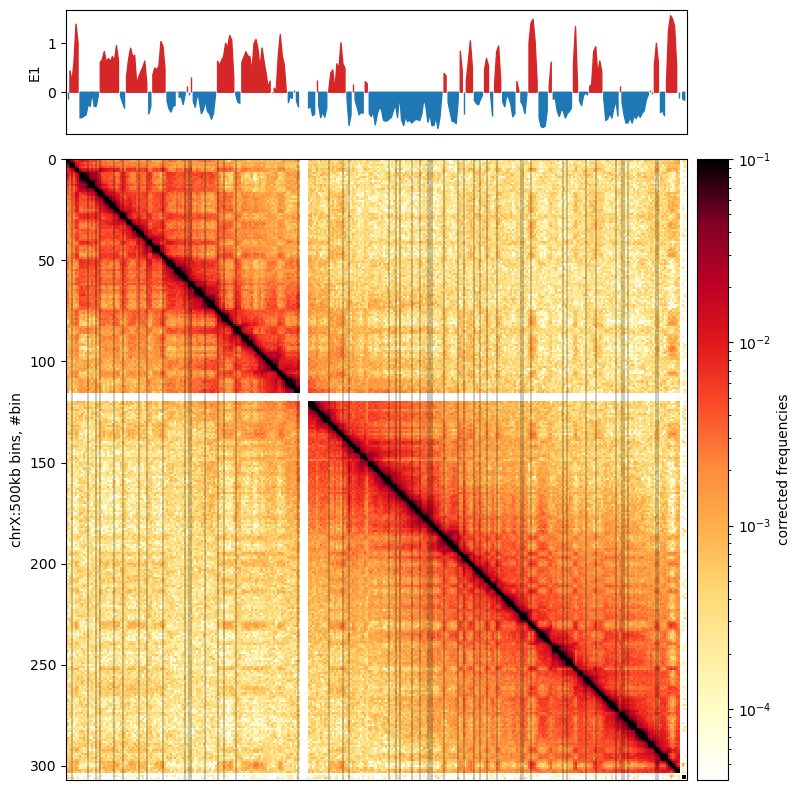

In [11]:
#| label: chrX-matrix-e1-500kb
#| fig-cap: "chrX interaction matrix with E1 eigenvector values. 500kb resolution"

chrX_matrix_e1_500kb()

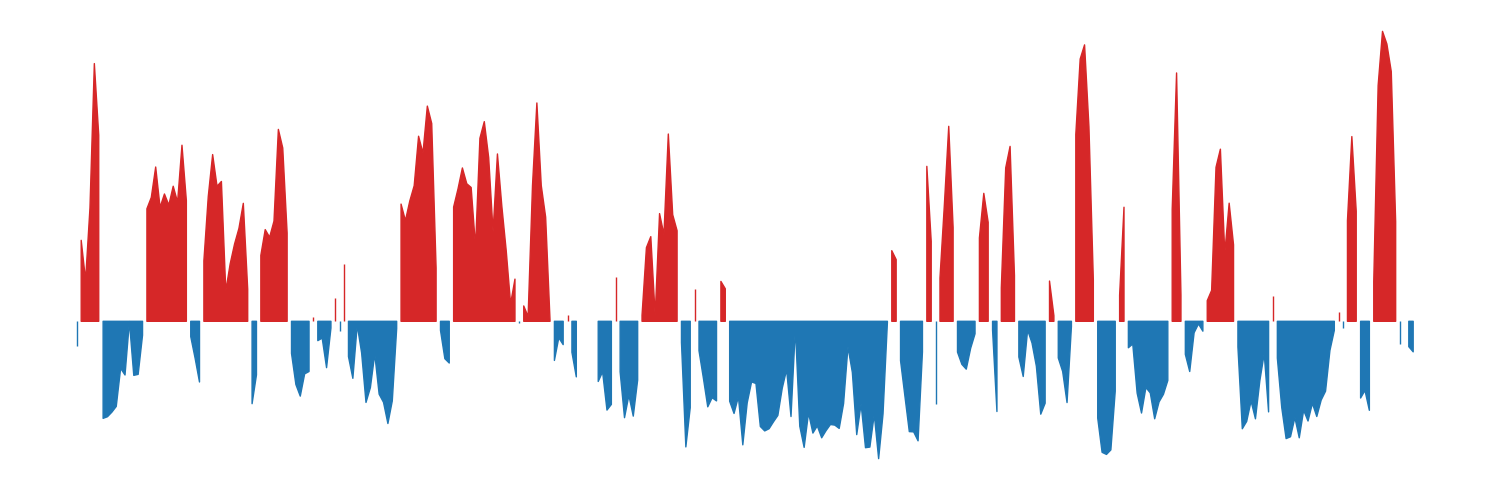

In [38]:
#| label: chrX-e1-500kb-plot
#| fig-cap: "500kb binned E1 eigenvector values for chrX. Freshly calculated from the cooler file."
#| fig-height: 1


import matplotlib.pyplot as plt

f, ax1 = plt.subplots(
    figsize=(15, 5),
)

# Fill between the line and 0
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values > 0), color='tab:red')
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values < 0), color='C0')

#ax1.set_ylabel('E1')
ax1.set_xticks([])
ax1.set_yticks([])

# Remove borders
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

plt.tight_layout()

# Save the plot as a high-resolution PNG file
#plt.savefig('e1_plot.png', dpi=320, bbox_inches='tight')

plt.show()

#### Stairs plot of the E1 compartments

(Less spiky, more smooth)



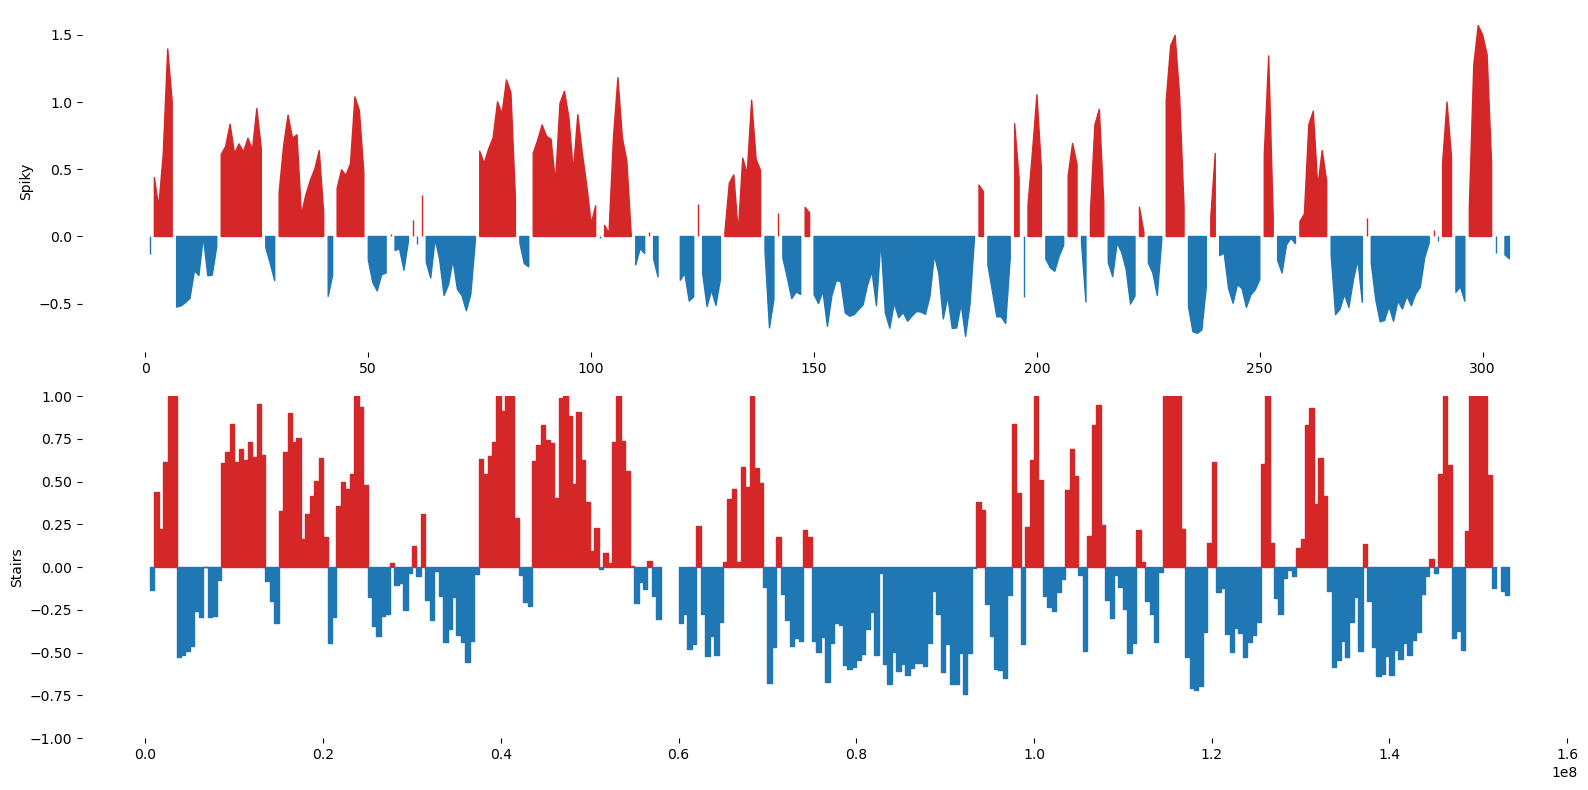

In [36]:
#| label: chrX-e1-500kb-stairs
#| fig-cap: "500kb binned E1 eigenvector values for chrX."
#| fig-height: 2


import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(2,1,
    figsize=(16, 8)
)

chrom_start = eigenvector_track_chrX['start'].values
window_size = chrom_start[1] - chrom_start[0]

# Fill between the line and 0
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values > 0), color='tab:red')
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values < 0), color='tab:blue')

# Create stairs
x = np.zeros(2*chrom_start.size)
y = np.zeros(2*chrom_start.size)
x[0::2] = chrom_start
x[1::2] = chrom_start + window_size
y[0::2] = e1X_values
y[1::2] = e1X_values

# Layout
ax1.set_ylabel('Spiky')
ax2.set_ylabel('Stairs')
#ax1.set_xticks([])
#ax1.set_yticks([])
ax2.set_ylim(-1, 1)

# Remove borders
ax1.spines[:].set_visible(False)
ax2.spines[:].set_visible(False)

ax2.fill_between(x, y, 0, where=(y > 0), color='tab:red')
ax2.fill_between(x, y, 0, where=(y < 0), color='tab:blue')

plt.tight_layout()
# Save the plot as a high-resolution PNG file
#plt.savefig('e1_plot.png', dpi=320, bbox_inches='tight')



### All 5 full merges

In [14]:
import glob
import os.path as op

mcools = glob.glob("../steps/bwa/PE/cool/*/*.mcool")
res = "::resolutions/500000"

clrs = {op.basename(op.dirname(mcool)): cooler.Cooler(mcool+res) for mcool in mcools}
clrs

{'round_spermatid': <Cooler "round_spermatid.mcool::/resolutions/500000">,
 'spermatogonia': <Cooler "spermatogonia.mcool::/resolutions/500000">,
 'sperm': <Cooler "sperm.mcool::/resolutions/500000">,
 'fibroblast': <Cooler "fibroblast.mcool::/resolutions/500000">,
 'pachytene_spermatocyte': <Cooler "pachytene_spermatocyte.mcool::/resolutions/500000">}

In [15]:
clrs['fibroblast'].fetch('chrX')

AttributeError: 'Cooler' object has no attribute 'fetch'